# Augmented Embeddings Experiment

## Load images

In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

def load_images():
    """Load images from the folder"""
    images = []
    for i in range(4):
        img = PIL.Image.open('./data/images/' + str(i + 1) + '.png')
        img = np.array(img)
        images.append(img)
    return images

images = load_images()
TOTAL_IMAGES = len(images)

Visualise images

In [ ]:
image = images[0]
# plt.imshow(image.rotate(0.5))
plt.axis('off')
plt.imshow(image)
image.shape

## Augmentation

Perform augmentations on images

In [ ]:
import albumentations as A

def perform_augmentation(image, augmentation):
    """Perform given augmentation on image and crop to appropriate size for ResNet 50"""

    transform = A.Compose([
        augmentation,
        A.CenterCrop(height=224, width=224),
    ])

    transformed_image = transform(image=image)['image']
    return transformed_image

def aug_rot(image, angle):
    """Augment image with rotation (int from 0 to 360)"""

    augmentation_rotate = A.Rotate((angle, angle), always_apply=True)
    return perform_augmentation(image, augmentation_rotate)

def aug_colour_jitter(image, hue, sat, val):
    """Colour jitter"""

    augmentation_hue = A.HueSaturationValue(
        hue_shift_limit=(hue, hue),
        sat_shift_limit=(sat, sat),
        val_shift_limit=(val, val),
        always_apply=True
    )
    return perform_augmentation(image, augmentation_hue)

def aug_hue(image, hue):
    """Augment image with hue (int from -100 to 100)"""

    return aug_colour_jitter(image, hue, 0, 0)

def aug_sat(image, sat):
    """Augment image with hue (int from -100 to 100)"""

    return aug_colour_jitter(image, 0, sat, 0)

def aug_val(image, val):
    """Augment image with hue (int from -100 to 100)"""

    return aug_colour_jitter(image, 0, 0, val)


Visualise augmented images

In [ ]:
transformed_image = aug_rot(image=image, angle=20)
# transformed_image = aug_hue(image=image, hue=50)
plt.axis('off')
plt.imshow(transformed_image)
transformed_image.shape

Convert PIL images into Pytorch tensors

In [ ]:
from torchvision import transforms as transform_lib

def convert_to_tensor(image):
    t = transform_lib.Compose([
        transform_lib.ToTensor(),
        transform_lib.CenterCrop(224),
        transform_lib.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        )
    ])

    image_tensor =  t(image)
    return image_tensor

Generate augmentation images for specified image and aug type

In [ ]:
def generate_aug_images(image, aug, z):
    aug_images = []
    for value in z:
        aug_image = aug(image, value)
        aug_image_tensor = convert_to_tensor(aug_image)
        aug_images.append(aug_image_tensor)
    return aug_images

## Retrieve embeddings

Modified ResNet 50 model

In [ ]:
# modified from Pytorch official resnet.py
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
from torchsummary import summary
import torch.nn.functional as F

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

class Bottleneck_Baseline(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Baseline(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super(ResNet_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1) 

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

def resnet50_baseline(pretrained=False):
    """Constructs a Modified ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_Baseline(Bottleneck_Baseline, [3, 4, 6, 3])
    if pretrained:
        model = load_pretrained_weights(model, 'resnet50')
    return model

def load_pretrained_weights(model, name):
    pretrained_dict = model_zoo.load_url(model_urls[name])
    model.load_state_dict(pretrained_dict, strict=False)
    return model

Feed augmented images to ResNet 50 and save embeddings

In [ ]:
model = resnet50_baseline(pretrained=True)

# only using one image for now
def get_embeddings(aug_images, batch_size=4):
    embeddings = {}
    # print(len(aug_images))
    runs = len(aug_images) // batch_size

    for i in range(runs):
        # print("Running batch {}/{}".format(i + 1, runs))
        batch = aug_images[i * batch_size : (i + 1) * batch_size]
        input = torch.stack(batch, dim=0)
        # print(input.shape)
        # input = input.cuda()

        output = model(input)
        output = output.cpu().detach().numpy()
        # print(output.shape)
        # output_list = output.tolist()
        for j in range(len(output)):
            # print(output[j].shape)
            embeddings[i * batch_size + j] = output[j]
        # print(len(embeddings[i]))
    return embeddings

## Experiment

Augmentation info stored in the `aug_info` dictionary

In [ ]:
aug_info = [
    { "key": "aug_rot", "aug_function": aug_rot, "col": 1, "title": "rotation", "z": [i for i in range(0, 360) if i != 0 and i % 90 != 0] },
    { "key": "aug_hue", "aug_function": aug_hue, "col": 2, "title": "hue shift", "z": [i for i in range(-100, 100)] },
    { "key": "aug_sat", "aug_function": aug_sat, "col": 3, "title": "saturation shift", "z": [i for i in range(-100, 100)] },
    { "key": "aug_val", "aug_function": aug_val, "col": 4, "title": "value shift", "z": [i for i in range(-100, 100)] },
    # { "key": "aug_zoom", "col": 5, "title": "zoom in/out", "aug_function": aug_zoom, "z": [i for i in range(-20, 20)] },
]

Data info will be stored in the `data` dictionary

In [ ]:
data = {}
for i in range(TOTAL_IMAGES):
    data[i + 1] = {}

Dimensionality reduction using TSNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

def reduce_dims_tsne(embeddings, dims=2):
    embeddings_list = np.asarray(list(embeddings.values()))
    embeddings_reduced = TSNE(n_components=dims, learning_rate='auto', init='random').fit_transform(embeddings_list)
    return embeddings_reduced

Run experiment

In [ ]:
for aug in aug_info:
    for i in range(1, TOTAL_IMAGES + 1):
        print(f"{aug['title']} - {i}/{TOTAL_IMAGES}")

        # augmentation
        data[i][aug["key"]] = generate_aug_images(images[i - 1], aug["aug_function"], aug["z"])
        
        # embeddings
        data[i]["embeddings_" + aug["key"]] = get_embeddings(data[i][aug["key"]], batch_size=4)

        # reduce dimensions
        data[i]["reduced_" + aug["key"]] = reduce_dims_tsne(dims = 2, embeddings = data[i]["embeddings_" + aug["key"]])

## Visualise results

Plot images with scatter graphs of their augmented embedding spaces

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(4 + 4 * len(aug_info), 10))
subfigs = fig.subfigures(1, (1 + len(aug_info)), width_ratios=[1] + [2] * len(aug_info))

# plot images
axs0 = subfigs[0].subplots(TOTAL_IMAGES, 1)
subfigs[0].suptitle('Images')
# subfigs[0].set_facecolor('0.9')
for i in range(TOTAL_IMAGES):
    axs0[i].imshow(images[i])
    axs0[i].axis('off')
    # axs0[i].set_title('Image {}'.format(i + 1))


def plot_aug_embeddings(col, z, title, key):
    # print("col: {}".format(col))
    axs = subfigs[col].subplots(TOTAL_IMAGES, 1)
    subfigs[col].suptitle(f"Embedding space after {title}")

    for i in range(1, TOTAL_IMAGES + 1):
        # print("- row: {}".format(i))
        x = data[i]["reduced_" + key][:, 0]
        y = data[i]["reduced_" + key][:, 1]

        scatter = axs[i - 1].scatter(x, y, c=z, cmap='viridis')

    subfigs[col].colorbar(scatter, ax=axs, shrink=0.6)


for aug in aug_info:
    print(f"Plotting embeddings after {aug['title']}")
    plot_aug_embeddings(aug["col"], aug["z"], aug["title"], aug["key"])


plt.show()

Experimenting with 3D plots

In [ ]:
# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

for aug in aug_info:
    for i in range(1, TOTAL_IMAGES + 1):
        print(f"{aug['title']} - {i}/{TOTAL_IMAGES}")

        # reduce dimensions
        data[i]["reduced_3d_" + aug["key"]] = reduce_dims_tsne(dims = 3, embeddings = data[i]["embeddings_" + aug["key"]])

<IPython.core.display.Javascript object>


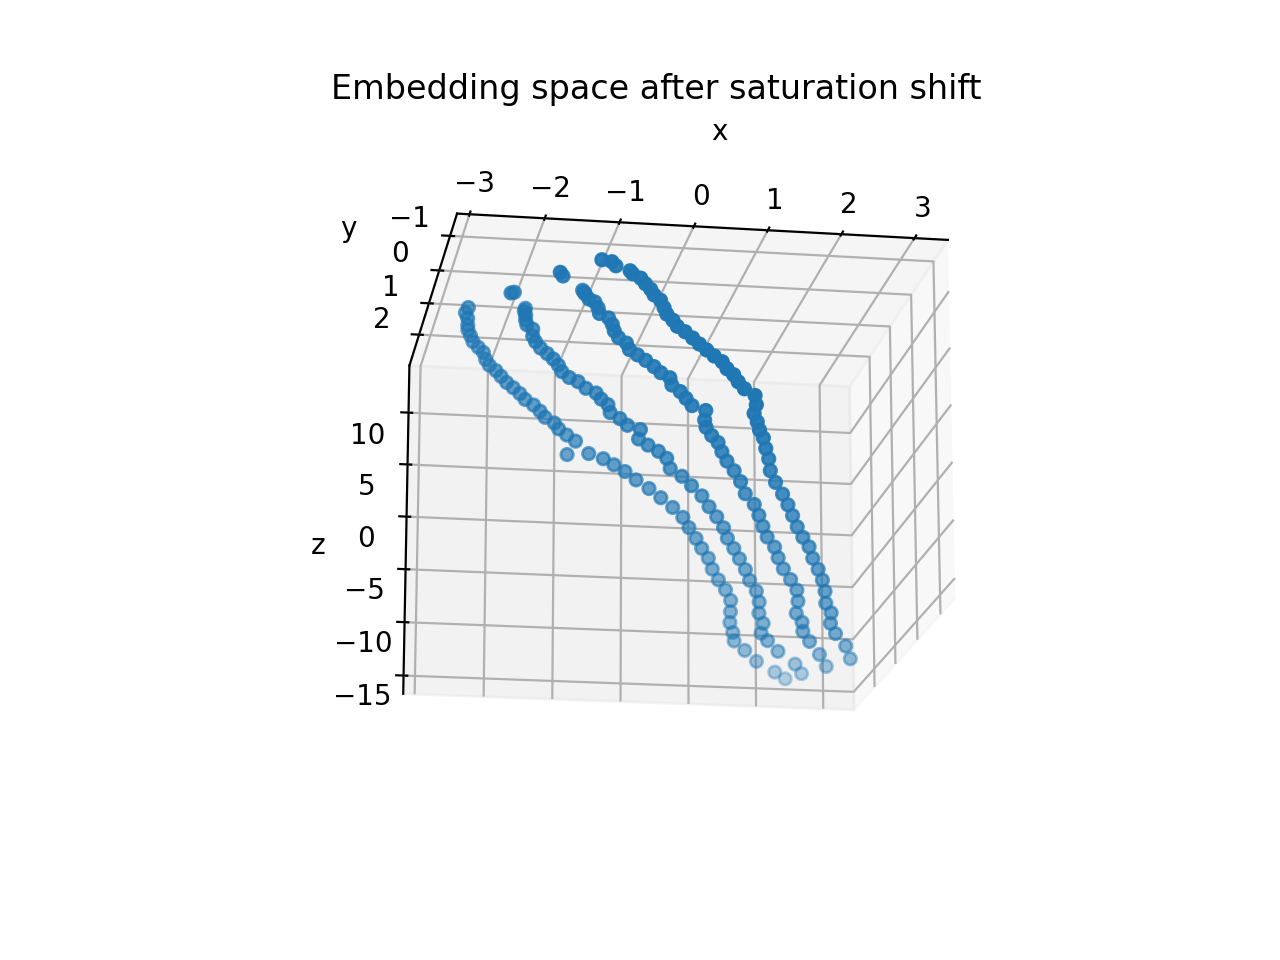

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

i = 1
aug = aug_info[2]
key = "reduced_3d" + aug['key']

ax.scatter(data[i][key][:, 0], data[i][key][:, 1], list(data[i][key][:, 2]))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title(f"Embedding space after {aug['title']}")
plt.show()